In [1]:
import numpy as np
import matplotlib.pyplot as plt

from snowScatt.fallSpeed import KhvorostyanovCurry2005 as KC05

from readARMdb import openScatteringRed
from radar import ZeARM
from radar import kdpARM
from PSDqN import PSDGamma3
from PSDqN import _loglog_interp

from readARMdb import InterpScattering


#####################################################################################
# Load scattering tables         ####################################################
#####################################################################################

subtype_agg = 'HD-P1d'
thick_ratio_den = 1.0
slanted_elev = 30

# 3-freq vertically pointing
aggX = openScatteringRed('aggregates', subtype=subtype_agg, band='X', elevation=90)
aggKa = openScatteringRed('aggregates', subtype=subtype_agg, band='Ka', elevation=90)
aggW = openScatteringRed('aggregates', subtype=subtype_agg, band='W', elevation=90)

denX = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='X', elevation=90)
denKa = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='Ka', elevation=90)
denW = openScatteringRed('dendrites', thick_ratio=thick_ratio_den, band='W', elevation=90)
#plates = openScatteringRed('plates', thick_ratio=1.0)

# polarimetric W-band 30deg elevation
agg_pol = openScatteringRed('aggregates', subtype='HD-P1d', band='W', elevation=slanted_elev)
den_pol = openScatteringRed('dendrites', thick_ratio=1.0, band='W', elevation=slanted_elev)
#columns = openScatteringRed('columns', thick_ratio=1.0)
#graupel = openScatteringRed('graupel')

#####################################################################################
# Derive interpolating functions ####################################################
#####################################################################################

aggXFunc = InterpScattering(aggX)
aggKaFunc = InterpScattering(aggKa)
aggWFunc = InterpScattering(aggW)

denXFunc = InterpScattering(denX)
denKaFunc = InterpScattering(denKa)
denWFunc = InterpScattering(denW)

aggPFunc = InterpScattering(agg_pol)
denPFunc = InterpScattering(den_pol)

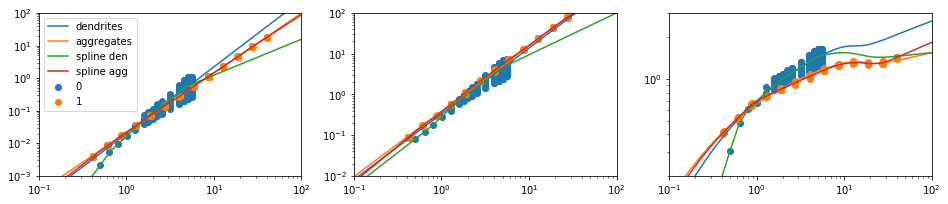

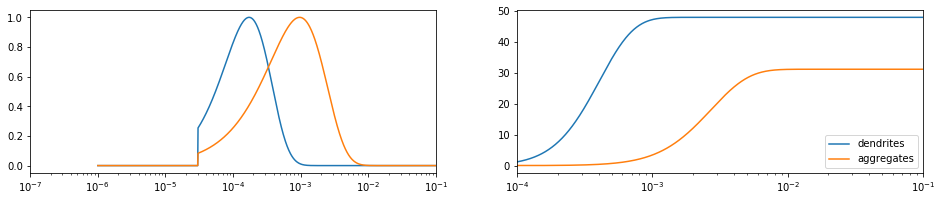

In [2]:
# First let's interpolate mD, aD relations to the aggregate particles selected in the database.
bm_agg, am_agg, mD_agg = _loglog_interp(1.0e-3*agg_pol.maximum_dimension, agg_pol.mass*1.0e-6)
# = lambda x: am_agg*x**bm_agg
ba_agg, aa_agg, aD_agg = _loglog_interp(1.0e-3*agg_pol.maximum_dimension, agg_pol.projected_area*1.0e-6)
#aD_agg = lambda x: aa_agg*x**ba_agg
# Then, create a wrapper of KC05 for aggregates that becomes a function of diameters only
vD_agg = lambda x: KC05(x, mD_agg(x), aD_agg(x))

# Repeate the same exercise for the dendrites
bm_den, am_den, mD_den = _loglog_interp(1.0e-3*den_pol.maximum_dimension, den_pol.mass*1.0e-6)
#mD_den = lambda x: am_den*x**bm_den
ba_den, aa_den, aD_den = _loglog_interp(1.0e-3*den_pol.maximum_dimension, den_pol.projected_area*1.0e-6)
#aD_den = lambda x: aa_den*x**ba_den
vD_den = lambda x: KC05(x, mD_den(x), aD_den(x))

# Now build PSDs for aggregates and dendrites for testing
N = 1.0e4
q = 1.0e-3
#PSDagg = PSDGamma3(q, N, mD_agg, mu=1.0, minD=0.3e-3)
PSDagg = PSDGamma3(q, N, lambda x:1.0e-6*aggPFunc('mass', x*1.0e3), mu=1.0, minD=0.3e-4)


N = 1.0e5
q = 1.0e-4
#PSDden = PSDGamma3(q, N, mD_agg, mu=1.5, minD=0.3e-4)
PSDden = PSDGamma3(q, N, lambda x:1.0e-6*denPFunc('mass', x*1.0e3), mu=1.5, minD=0.3e-4)


fig, (axm, axa, axv) = plt.subplots(1, 3, figsize=(16,3))
for p, particle in enumerate([den_pol, agg_pol]):
    axm.scatter(particle.maximum_dimension, particle.mass, label=p)
    axa.scatter(particle.maximum_dimension, particle.projected_area, label=p)
    axv.scatter(particle.maximum_dimension, KC05(particle.maximum_dimension*1.0e-3, 
                                                 particle.mass*1.0e-6, 
                                                 particle.projected_area*1.0e-6), label=p)
D = np.logspace(-6, np.log10(0.1), 1000)
axm.plot(D*1.0e3, 1.0e6*mD_den(D), label='dendrites')
axm.plot(D*1.0e3, 1.0e6*mD_agg(D), label='aggregates')
axm.plot(D*1.0e3, denPFunc('mass', D*1.0e3), label='spline den')
axm.plot(D*1.0e3, aggPFunc('mass', D*1.0e3), label='spline agg')
axa.plot(D*1.0e3, 1.0e6*aD_den(D))
axa.plot(D*1.0e3, 1.0e6*aD_agg(D))
axa.plot(D*1.0e3, denPFunc('projected_area', D*1.0e3), label='spline den')
axa.plot(D*1.0e3, aggPFunc('projected_area', D*1.0e3), label='spline agg')
axv.plot(D*1.0e3, vD_den(D))
axv.plot(D*1.0e3, vD_agg(D))
axv.plot(D*1.0e3, KC05(D, 1.0e-6*denPFunc('mass', D*1.0e3), 1.0e-6*denPFunc('projected_area', D*1.0e3)), label='spline den')
axv.plot(D*1.0e3, KC05(D, 1.0e-6*aggPFunc('mass', D*1.0e3), 1.0e-6*aggPFunc('projected_area', D*1.0e3)), label='spline agg')

axm.set_xscale('log')
axm.set_yscale('log')
axm.set_xlim(1.0e-1, 1e2)
axm.set_ylim(1.0e-3, 1e2)
axm.legend()
axa.set_xscale('log')
axa.set_yscale('log')
axa.set_xlim(1.0e-1, 1e2)
axa.set_ylim(1.0e-2, 1.0e2)
axv.set_xscale('log')
axv.set_yscale('log')
axv.set_xlim(1.0e-1, 1e2)
axv.set_ylim(2.0e-1, 3e0)

fig, (ax, axm) = plt.subplots(1, 2, figsize=(16,3))
ax.plot(D, PSDden(D)/np.max(PSDden(D)))
ax.plot(D, PSDagg(D)/np.max(PSDagg(D)))
ax.set_xscale('log')
ax.set_xlim(1.0e-7, 0.1)

axm.plot(D, np.cumsum(PSDden(D)*mD_den(D)), label='dendrites')
axm.plot(D, np.cumsum(PSDagg(D)*mD_agg(D)), label='aggregates')
#axm.set_yscale('log')
axm.set_xscale('log')
axm.set_xlim(1.0e-4, 0.1)
axm.legend(loc=4)

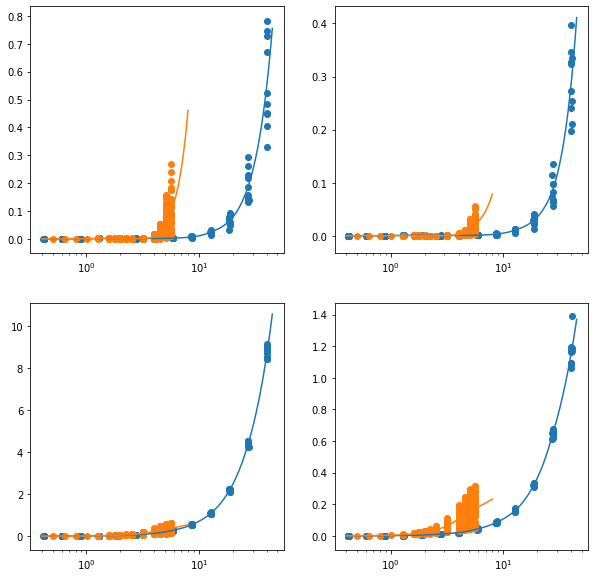

In [3]:
# What I know
"""
sigma_backward_hh == tmatrix.radar.radar_xsect from tmatrix   [mm2] which is 2*pi* Zhh
to get reflectivity Zhh = wl**4 * pi**-5 K2**-1 * int(sigma_hh) 


"""
# Let's check if the interpolators work ok

d = np.logspace(np.log10(0.4), np.log10(45), 1000)
dd = np.logspace(np.log10(0.4), np.log10(8), 1000)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(agg_pol.maximum_dimension, agg_pol.sigma_backward_hh)
axs[0, 0].scatter(den_pol.maximum_dimension, den_pol.sigma_backward_hh)
axs[0, 0].plot(d, aggPFunc('sigma_backward_hh', d))
axs[0, 0].plot(dd, denPFunc('sigma_backward_hh', dd))


axs[0, 1].scatter(agg_pol.maximum_dimension, agg_pol.sigma_backward_vv)
axs[0, 1].scatter(den_pol.maximum_dimension, den_pol.sigma_backward_vv)
axs[0, 1].plot(d, aggPFunc('sigma_backward_vv', d))
axs[0, 1].plot(dd, denPFunc('sigma_backward_vv', dd))

axs[1, 0].scatter(agg_pol.maximum_dimension, agg_pol.Shh_forward_real)
axs[1, 0].scatter(den_pol.maximum_dimension, den_pol.Shh_forward_real)
axs[1, 0].plot(d, aggPFunc('Shh_forward_real', d))
axs[1, 0].plot(dd, denPFunc('Shh_forward_real', dd))

axs[1, 1].scatter(agg_pol.maximum_dimension, agg_pol.Shh_forward_real-agg_pol.Svv_forward_real)
axs[1, 1].scatter(den_pol.maximum_dimension, den_pol.Shh_forward_real-den_pol.Svv_forward_real)
axs[1, 1].plot(d, aggPFunc('Shh_forward_real', d)-aggPFunc('Svv_forward_real', d))
axs[1, 1].plot(dd, denPFunc('Shh_forward_real', dd)-denPFunc('Svv_forward_real', dd))

for ax in axs.flatten():
    ax.set_xscale('log')
    #ax.set_yscale('log')

In [4]:
from readARMdb import _get_Dmax_bins, _get_mean_grouped_ds
bin_edges = _get_Dmax_bins(agg_pol)
#plt.figure()
#plt.scatter(agg_pol.maximum_dimension, agg_pol.sigma_backward_hh)
#plt.vlines(bin_edges, ymin=1.0e-6, ymax=1.0)
#plt.xscale('log')
agg_grp = agg_pol.groupby_bins('maximum_dimension', bin_edges)
aggAVG = agg_grp.mean()
aggAVG2 = _get_mean_grouped_ds(agg_pol)

bin_edges = _get_Dmax_bins(den_pol)
#plt.figure()
#plt.scatter(den_pol.maximum_dimension, den_pol.sigma_backward_hh)
#plt.vlines(bin_edges, ymin=1.0e-6, ymax=0.1)
#plt.xscale('log')
den_grp = den_pol.groupby_bins('maximum_dimension', bin_edges)
denAVG = den_grp.mean()
denAVG2 = _get_mean_grouped_ds(den_pol)

In [5]:
denPFunc('sigma_backward_hh', 3.0), denPFunc('sigma_backward_vv', 3.0), aggPFunc('sigma_backward_hh', 3.0), aggPFunc('sigma_backward_vv', 3.0)

(0.0010503335815768592,
 0.00035732845923292243,
 0.0010206701840920192,
 0.0004615250032036217)

In [6]:
(0.0010503335815768592,
 0.00035732845923292243,
 0.0010206701840920192,
 0.0004615250032036217)

(0.0010503335815768592,
 0.00035732845923292243,
 0.0010206701840920192,
 0.0004615250032036217)

In [8]:
np.max(denAVG.maximum_dimension)

<xarray.DataArray 'maximum_dimension' ()>
array(5.63170195)
Coordinates:
    incident_polar_angle  float32 60.0
    wavelength            float32 3.19

In [8]:
PSDden.calc_q(), PSDagg.calc_q()

(9.999999943019503e-05, 0.0009999999785605248)

In [9]:
PSDden.integrate(lambda x : 1.0e-6*denPFunc('mass', x*1.0e3))

9.999999943019503e-05

In [10]:
PSDagg.integrate(lambda x : 1.0e-6*aggPFunc('mass', x*1.0e3))

0.0009999999785605248

In [11]:
PSDden.integrate(lambda x : denPFunc('Shh_forward_real', x*1.0e3)-denPFunc('Svv_forward_real', x*1.0e3))

44.189508779776496

In [9]:
ZeARM(PSDagg, aggPFunc, 'W', 'hh')-ZeARM(PSDagg, aggPFunc, 'W', 'vv')

dB = lambda x : 10.0*np.log10(x)
def radarSnow2parts(qa, Na, qd, Nd):
    """ Compute snow radar quantities from 2 populations of particles
    defined by 2-mom Gamma3 PSDs and beeing dendrites and aggregates
    """
    PSDagg = PSDGamma3(qa, Na, lambda x:1.0e-6*aggPFunc('mass', x*1.0e3), mu=1.0, minD=0.3e-4, maxD=0.04)
    PSDden = PSDGamma3(qd, Nd, lambda x:1.0e-6*denPFunc('mass', x*1.0e3), mu=1.5, minD=0.3e-4, maxD=0.006)
    
    Dhh = ZeARM(PSDden, denPFunc, 'W', 'hh') 
    Dvv = ZeARM(PSDden, denPFunc, 'W', 'vv')
    Ahh = ZeARM(PSDagg, aggPFunc, 'W', 'hh')
    Avv = ZeARM(PSDagg, aggPFunc, 'W', 'vv')
    
    Zdr = dB((Dhh+Ahh)/(Dvv+Avv))
    kdp = kdpARM(PSDden, denPFunc, 'W')+kdpARM(PSDagg, aggPFunc, 'W')
    
    Zx = ZeARM(PSDden, denXFunc, 'X') + ZeARM(PSDagg, aggXFunc, 'X')
    Zka = ZeARM(PSDden, denKaFunc, 'Ka') + ZeARM(PSDagg, aggKaFunc, 'Ka')
    Zw = ZeARM(PSDden, denWFunc, 'W') + ZeARM(PSDagg, aggWFunc, 'W')
    
    return dB(Zx), dB(Zka), dB(Zw), Zdr, kdp
vRadar = np.vectorize(radarSnow2parts)

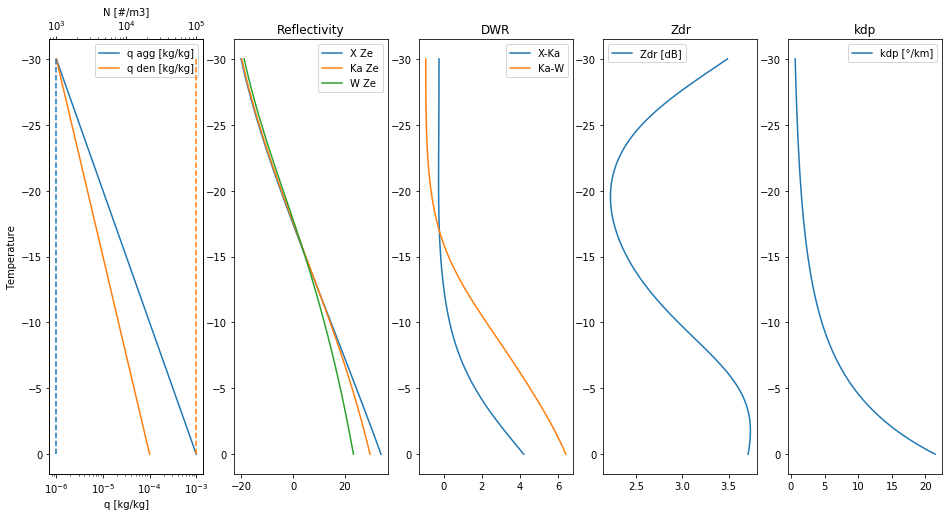

In [10]:
Nlevels = 100
T = np.linspace(-30, 0, Nlevels)
qa = np.logspace(-6, -3, Nlevels) #(T+30)*0.0 + 1.0e-3
Na = np.logspace(3, 3, Nlevels) #(T+30)*0.0 + 1.0e3
qd = np.logspace(-6, -4, Nlevels) #(T+30)*0.0 + 1.0e-4
Nd = np.logspace(5, 5, Nlevels) #(T+30)*0.0 + 1.0e5
Zx, Zka, Zw, Zdr, kdp = vRadar(qa, Na, qd, Nd)
#Zx, Zka, Zw, Zdr, kdp = radarSnow2parts(qa[0], Na[0], qd[0], Nd[0])

fig, axs = plt.subplots(1, 5, figsize=(16, 8))
axs[0].plot(qa, T, label='q agg [kg/kg]')
axs[0].plot(qd, T, label='q den [kg/kg]')
axs[0].set_xscale('log')
axs[0].set_xlabel('q [kg/kg]')
axt = axs[0].twiny()
axt.plot(Na, T, ls='--', label='N agg [#/m3]')
axt.plot(Nd, T, ls='--', label='N den [#/m3]')
axt.set_xscale('log')
axt.set_xlabel('N [#/m3]')


axs[1].plot(Zx, T, label='X Ze')
axs[1].plot(Zka, T, label='Ka Ze')
axs[1].plot(Zw, T, label='W Ze')
axs[1].set_title('Reflectivity')

axs[2].plot(Zx-Zka, T, label='X-Ka')
axs[2].plot(Zka-Zw, T, label='Ka-W')
axs[2].set_title('DWR')

axs[3].plot(Zdr, T, label='Zdr [dB]')
axs[3].set_title('Zdr')

axs[4].plot(kdp, T, label='kdp [°/km]')
axs[4].set_title('kdp')

axs[0].set_ylabel('Temperature')
for ax in axs:
    ax.invert_yaxis()
    ax.legend()
fig.savefig('idealized_simulations.png', dpi=300)